In [1]:
from sym_utils import *
%matplotlib inline

C:\Users\cdipt\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\cdipt\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Using cpu device


In [2]:
def oracle_norm(data):
    return torch.norm(data,dim=1)

#if n_dim==4:
def oracle_lorentz(data):
     return (data[:,0].reshape(data.shape[0],1))**2 \
             - (data[:,1].reshape(data.shape[0],1))**2 \
             - (data[:,2].reshape(data.shape[0],1))**2 \
             - (data[:,3].reshape(data.shape[0],1))**2   #- torch.sum( (data[:,1:].reshape(data.shape[0],3))**2,dim=1)

#if n_dim==2:
def oracle_squeeze(data):
    return (data[:,0]*data[:,1]).reshape(data.shape[0],1)

def oracle_piecewise_linear(data):
    a = data[:,0]
    b = -data[:,1]
    return torch.where(a >= 0, a, b)

def oracle_manhattan(data):
    return torch.abs(data[:,0])+torch.abs(data[:,1])

In [3]:
n       = 300
n_dim   = 3
n_gen   = 3    #int(n_dim*(n_dim-1)/2)
n_com   = int(n_gen*(n_gen-1)/2)
eps     = 1e-3
lr      = 1e-3
epochs  = 5000
oracle = oracle_norm

Epoch 1   |  Train Loss: 7.367966140804603
Epoch 101   |  Train Loss: 4.905572917179532
Epoch 201   |  Train Loss: 3.049545046296267
Epoch 301   |  Train Loss: 2.177601272778217
Epoch 401   |  Train Loss: 1.7806495443085733
Epoch 501   |  Train Loss: 1.590707330234767
Epoch 601   |  Train Loss: 1.469257715870485
Epoch 701   |  Train Loss: 1.3691446777691803
Epoch 801   |  Train Loss: 1.2694726675505728
Epoch 901   |  Train Loss: 1.1512492321103547
Epoch 1001   |  Train Loss: 0.999671329562919
Epoch 1101   |  Train Loss: 0.8220582300735483
Epoch 1201   |  Train Loss: 0.6461147165706689
Epoch 1301   |  Train Loss: 0.48909407800242966
Epoch 1401   |  Train Loss: 0.353697167518955
Epoch 1501   |  Train Loss: 0.24025074870073285
Epoch 1601   |  Train Loss: 0.15227109459096255
Epoch 1701   |  Train Loss: 0.09031615594412842
Epoch 1801   |  Train Loss: 0.05050260939717322
Epoch 1901   |  Train Loss: 0.026837256550166652
Epoch 2001   |  Train Loss: 0.013656648425183892
Epoch 2101   |  Train Lo

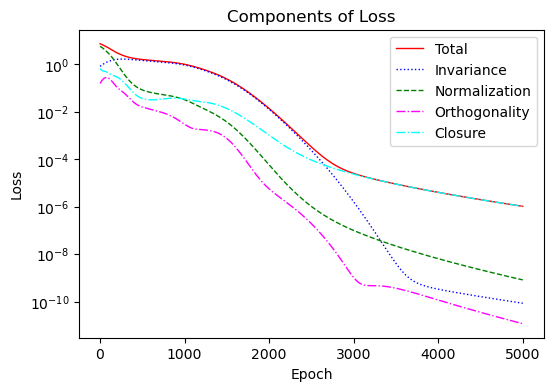

In [4]:
# Set Random Seeds
np.random.seed(0)
torch.manual_seed(0)
include_sc = True
struc_pred, gens_pred = run_model( n      = n,
                                   n_dim  = n_dim,
                                   n_gen  = n_gen,
                                   n_com  = n_com,
                                   eps    = eps,
                                   lr     = lr,
                                   epochs = epochs,
                                   oracle = oracle,
                                   include_sc = include_sc)

In [5]:
data = torch.tensor(np.random.randn(n,n_dim))
initialize_struc_const = torch.tensor(np.random.randn(n_com,n_gen))

In [16]:
data.shape

torch.Size([300, 3])

In [6]:
def bracket(A, B):
    return A @ B - B @ A

In [7]:
class find_generators(nn.Module):
        def __init__(self,n_dim,n_gen,n_com):
            super(find_generators,self).__init__() 

            G = [ nn.Linear(in_features = n_dim, out_features = n_dim, bias = False) for _ in range(n_gen)]

            self.gens = nn.ModuleList(G)


            C = [ nn.Sequential( nn.Linear(in_features = n_gen, out_features = n_gen, bias = True),
                             nn.ReLU(),
                             nn.Linear(in_features = n_gen, out_features = n_gen, bias = True),
                             nn.ReLU(),
                             nn.Linear(in_features = n_gen, out_features = n_gen, bias = True) ) for _ in range(n_com) ]

            self.struct_const = nn.ModuleList(C)

            self.n_gen = n_gen
            self.n_dim = n_dim
            self.n_com = n_com

        def forward(self, c, include_sc):

            generators = [ gen[:,:] for gen in self.gens.parameters() ]

            structure_constants = torch.zeros((self.n_com,self.n_gen))

            if include_sc:
                structure_constants = torch.empty((self.n_com,self.n_gen))
                for i in range(self.n_com):
                    structure_constants[i,:] = ( self.struct_const[i](c[i].flatten()) ).reshape(1,self.n_gen)

            return structure_constants, generators

In [8]:
model = find_generators(n_dim,n_gen,n_com).to(device)

In [17]:
model

find_generators(
  (gens): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=False)
    (1): Linear(in_features=3, out_features=3, bias=False)
    (2): Linear(in_features=3, out_features=3, bias=False)
  )
  (struct_const): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, out_features=3, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, out_features=3, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=3, bias=True)
      (3): ReLU()
      (4): Linear(in_features=3, out_features=3, bias=True)
    )
  )
)

In [9]:
def loss_fn(data,generators,struc_const,eps,ainv=1,anorm=1,aorth=1,aclos=1,include_sc=True):
    
        lossi = 0.
        lossn = 0.
        losso = 0.
        lossc = 0.
        comm_index = 0
    
        for i, G in enumerate(generators): 
            transform = torch.transpose((torch.eye(G.shape[0]) + eps*G)@torch.transpose(data,dim0=1,dim1=0), dim0=1,dim1=0 )
            transform = transform.reshape(data.shape[0],data.shape[1])

            lossi  += torch.mean( ( oracle(transform) - oracle(data) )**2 ) / eps**2 
            lossn  += (torch.sum(G**2) - 2)**2
            
            for j, H in enumerate(generators):
                if i < j:
                    losso += torch.sum(G*H)**2
                    
                    if include_sc:
                        C1 = bracket(G,H)
                        C2 = 0
                        for k,K in enumerate(generators):
                            C2 += struc_const[comm_index,k]*K
                        C = C1 - C2
                        lossc += torch.sum(C**2)**2
                        comm_index +=1
                        
        components= [ ainv*lossi,  anorm*lossn,  aorth*losso,  aclos*lossc ]

        L = ainv*lossi + anorm*lossn + aorth*losso + aclos*lossc #+ lossspsc + lossspg
        return  L, components

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
def train(initial_struc_const, 
              data, 
              model, 
              loss_fn, 
              epochs, 
              optimizer, 
              eps, 
              include_sc):
        
        history = {'train_loss': [],
                   'components_loss':[]} 
    
        start = time()
    
        ainv = 1.
        anorm = 1.
        aorth = 1.
        aclos = 0.
        if include_sc:
            aclos = 1.
    
        Y = initial_struc_const
    
        for i in range(epochs):
            train_loss = 0.
            model.train()
            struc_const, gens = model(Y,include_sc)
        
            loss, comp_loss = loss_fn( data         = data,
                            generators   = gens,
                            struc_const  = struc_const,
                            eps          = eps,
                            ainv         = ainv,
                            anorm        = anorm,
                            aorth        = aorth,
                            aclos        = aclos,
                            include_sc   = include_sc)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()
            comp_loss_for_epoch = []
        
            for j in range(len(comp_loss)):
                if torch.is_tensor(comp_loss[j]):
                    comp_loss_for_epoch.append(comp_loss[j].data.item())
                else:
                    comp_loss_for_epoch.append(comp_loss[j])
                
            history['train_loss'].append(train_loss)
            history['components_loss'].append(comp_loss_for_epoch)
        
            if i%100==0:
                print(f"Epoch {i+1}   |  Train Loss: {train_loss}")#,end='\r') #{train_loss:>8f}
            if i==epochs-1:
                print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
    
            if train_loss*1e25 < 1:
                print()
                print('Reached Near Machine Zero')
                break
    
        end = time()
        total_time = end-start
        print(f'Total Time: {total_time:>.8f}')
        print("Complete.")
        return {'history': history}

In [12]:
training = train( initial_struc_const = initialize_struc_const,
                  data                = data,
                  model               = model, 
                  loss_fn             = loss_fn,
                  epochs              = epochs,
                  optimizer           = optimizer,
                  eps                 = eps,
                  include_sc          = include_sc)

Epoch 1   |  Train Loss: 6.7405661361236415
Epoch 101   |  Train Loss: 4.469598436998263
Epoch 201   |  Train Loss: 2.7242369605926062
Epoch 301   |  Train Loss: 1.7582947798013044
Epoch 401   |  Train Loss: 1.401439685857082
Epoch 501   |  Train Loss: 1.223131499821805
Epoch 601   |  Train Loss: 1.076633780938262
Epoch 701   |  Train Loss: 0.9220228805307142
Epoch 801   |  Train Loss: 0.7546615168656209
Epoch 901   |  Train Loss: 0.592064452979606
Epoch 1001   |  Train Loss: 0.44893073589447163
Epoch 1101   |  Train Loss: 0.32995012467383056
Epoch 1201   |  Train Loss: 0.23600355327495143
Epoch 1301   |  Train Loss: 0.16494673223738354
Epoch 1401   |  Train Loss: 0.11293742587996307
Epoch 1501   |  Train Loss: 0.07590328228595229
Epoch 1601   |  Train Loss: 0.050117215487079286
Epoch 1701   |  Train Loss: 0.03251790459572672
Epoch 1801   |  Train Loss: 0.02073798511588886
Epoch 1901   |  Train Loss: 0.013004631408944381
Epoch 2001   |  Train Loss: 0.008023504262527008
Epoch 2101   |  

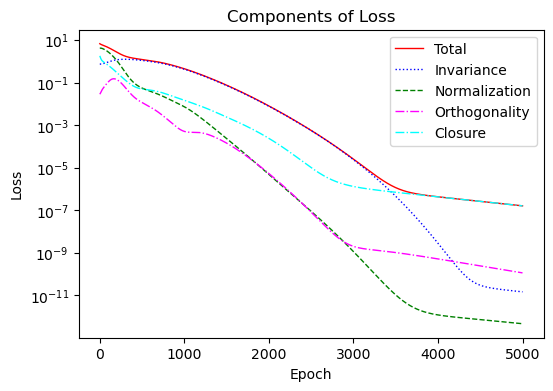

In [13]:
if n_gen>1:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.array(training['history']['components_loss'])
else:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.empty( ( train_loss.shape[0],len(training['history']['components_loss']) ) )
    for i,comp in enumerate(training['history']['components_loss']):
        for j,term in enumerate(comp):
            if torch.is_tensor(term) and term.requires_grad:
                comp_loss[i,j] = term.detach().numpy()
            else:
                comp_loss[i,j] = term

N=train_loss.shape[0]
plt.figure(figsize=(6,4))   #, dpi=100)
plt.plot( train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.plot(comp_loss[:N,0], linewidth=1, linestyle=':',  color='b',   label='Invariance')
plt.plot(comp_loss[:N,1], linewidth=1, linestyle='--', color='g',   label='Normalization')
plt.plot(comp_loss[:N,2], linewidth=1, linestyle='-.', color='magenta', label='Orthogonality')
plt.plot(comp_loss[:N,3], linewidth=1, linestyle='-.', color='cyan', label='Closure')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

# Evaluate Model
model.eval()

with torch.no_grad():
    struc_pred, gens_pred = model(initialize_struc_const,include_sc)
